#**ML Assignment 3: Image Data**
**Group TN01 - Team SEML31**  
**Dataset:** [Cards Image Dataset](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification?select=cards.csv)

# 1. Download and Import Data

In [ ]:
!mkdir datasets
!curl -L -o ./datasets/carddateset.zip\
  https://www.kaggle.com/api/v1/datasets/download/gpiosenka/cards-image-datasetclassification
!unzip -o ./datasets/carddateset.zip -d ./datasets/
#data saved in '/content/datasets/'

Streaming output truncated to the last 5000 lines.
  inflating: ./datasets/train/jack of spades/059.jpg  
  inflating: ./datasets/train/jack of spades/060.jpg  
  inflating: ./datasets/train/jack of spades/061.jpg  
  inflating: ./datasets/train/jack of spades/062.jpg  
  inflating: ./datasets/train/jack of spades/063.jpg  
  inflating: ./datasets/train/jack of spades/064.jpg  
  inflating: ./datasets/train/jack of spades/065.jpg  
  inflating: ./datasets/train/jack of spades/066.jpg  
  inflating: ./datasets/train/jack of spades/067.jpg  
  inflating: ./datasets/train/jack of spades/068.jpg  
  inflating: ./datasets/train/jack of spades/069.jpg  
  inflating: ./datasets/train/jack of spades/070.jpg  
  inflating: ./datasets/train/jack of spades/071.jpg  
  inflating: ./datasets/train/jack of spades/072.jpg  
  inflating: ./datasets/train/jack of spades/073.jpg  
  inflating: ./datasets/train/jack of spades/074.jpg  
  inflating: ./datasets/train/jack of spades/075.jpg  
  inflating: .

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 2. EDA (Exploratory Data Analysis)

In [ ]:
# Define the data directories
train_data_dir = '/content/datasets/train/'
val_data_dir = '/content/datasets/valid/'
test_data_dir = '/content/datasets/test/'

Image size, number of channels and label count

In [ ]:
#image size, num_chanels of train/validation/test dataset
def get_unique_info(data_dir, name="Dataset"):
    sizes = set()
    channels = set()
    mode_set = set()
    ds = ImageFolder(data_dir, transform=None)
    for img, _ in ds:
        sizes.add(img.size)  # (width, height)
        mode = img.mode
        mode_set.add(mode)
        if mode == "RGB":
            channels.add(3)
        elif mode in ["L", "1", "P"]:
            channels.add(1)
        elif mode == "RGBA":
            channels.add(4)
        elif mode == "CMYK":
            channels.add(4)
        else:
            channels.add(f"Unknown ({mode})")
    print(f"{name} set:")
    print("  Image sizes:", *list(sizes))
    print("  Number channel counts:", *list(channels))
    print("  Color modes:", *list(mode_set))


get_unique_info(train_data_dir, "Train")
print('--------------------------')
get_unique_info(val_data_dir, "Validation")
print('--------------------------')
get_unique_info(test_data_dir, "Test")

Train set:
  Image sizes: (224, 224)
  Number channel counts: 3
  Color modes: RGB
--------------------------
Validation set:
  Image sizes: (224, 224)
  Number channel counts: 3
  Color modes: RGB
--------------------------
Test set:
  Image sizes: (224, 224)
  Number channel counts: 3
  Color modes: RGB


In [ ]:
#labels name
target_to_class = {v: k for k, v in ImageFolder(train_data_dir).class_to_idx.items()}
print(f'Label size: {len(target_to_class)}')
target_to_class

Label size: 53


{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

Some sample image visualization

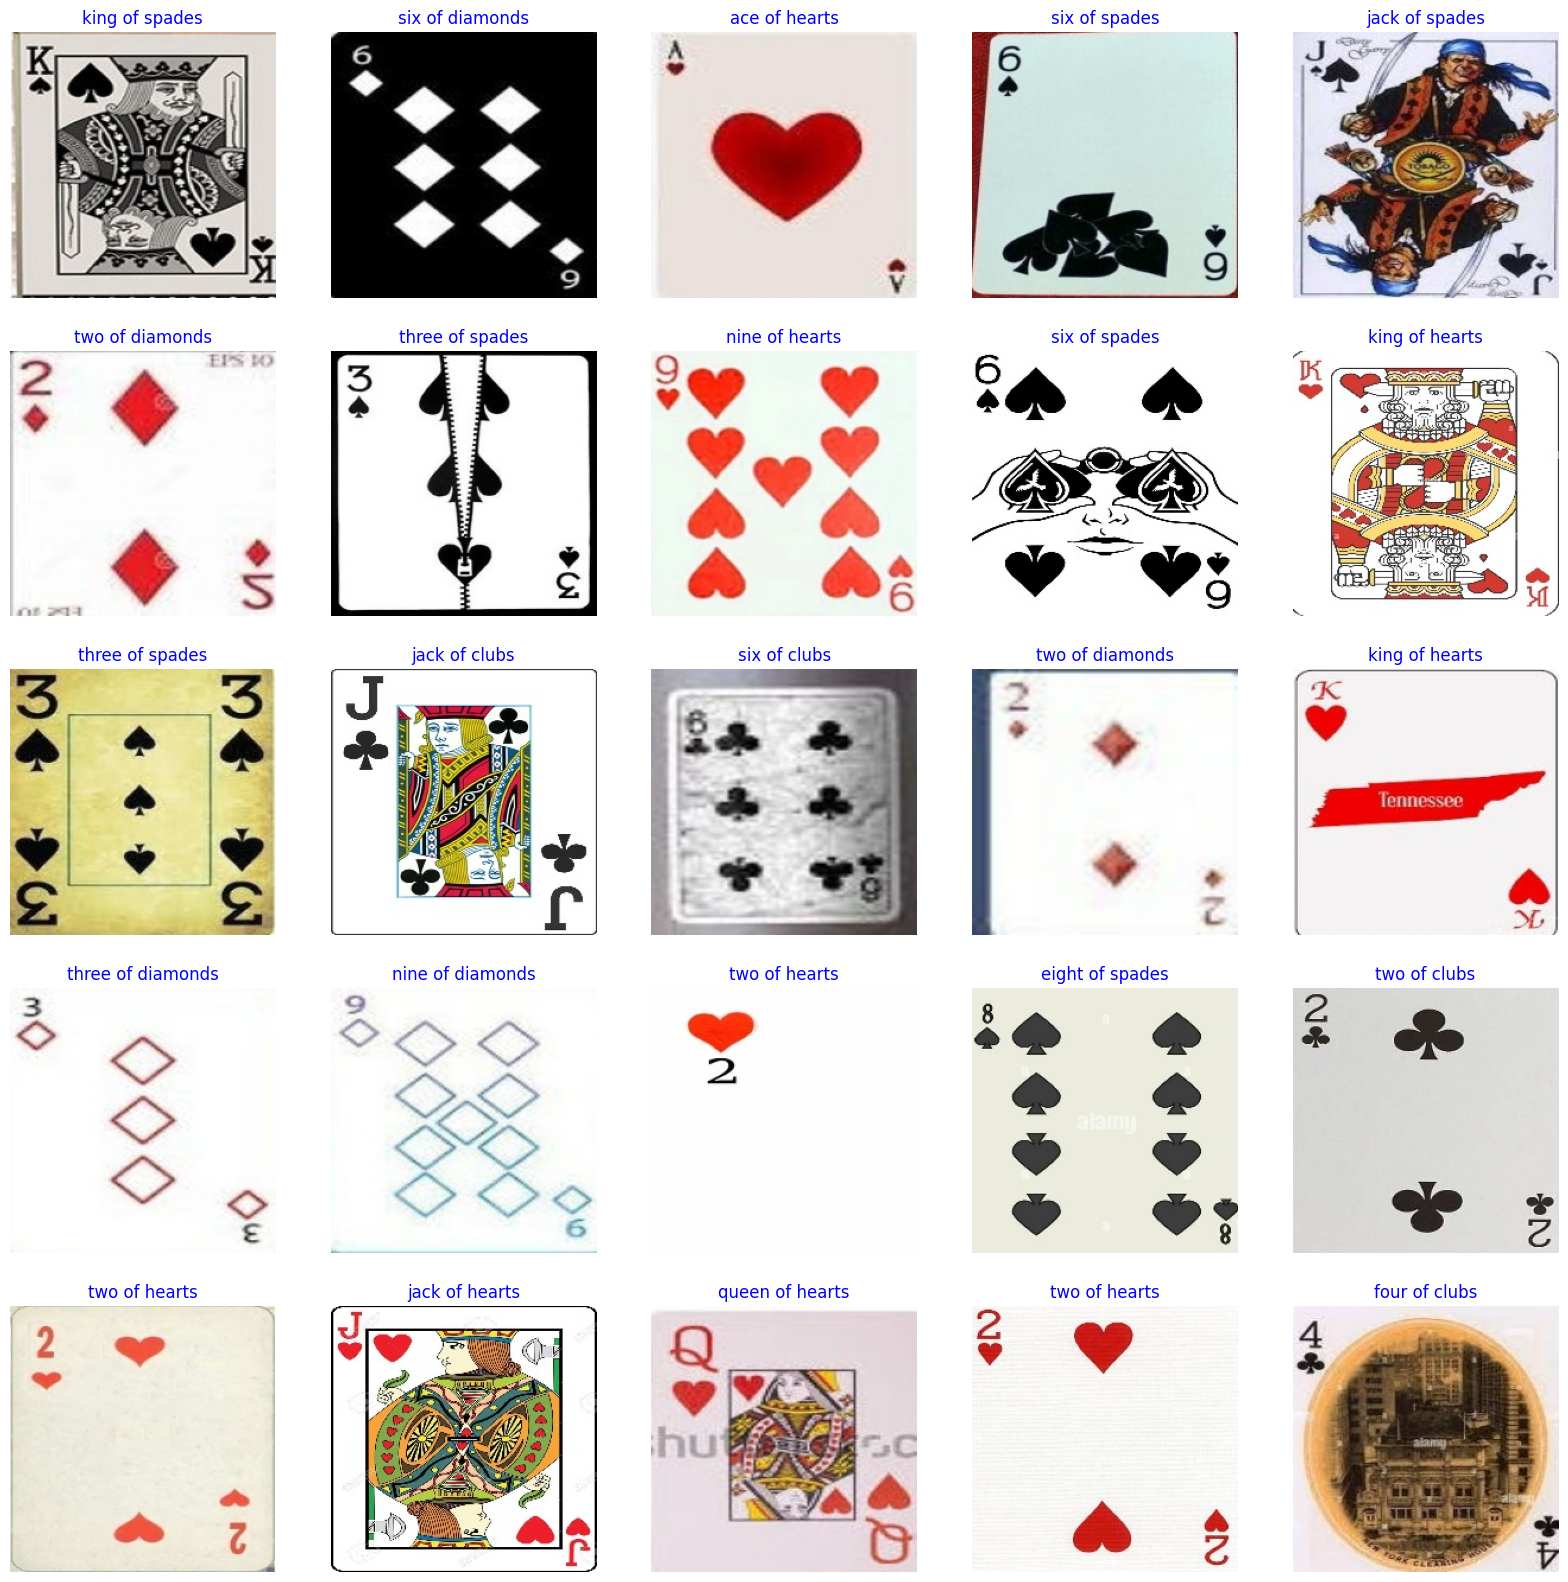

In [ ]:
# sample image visualization
def show_images(data_dir, batch_size, n=25):
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
    ds = ImageFolder(data_dir,transform=transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    images, labels = next(iter(loader))
    target_to_class = {v: k for k, v in ds.class_to_idx.items()}
    classes = list(target_to_class.values())
    plt.figure(figsize=(20,20))
    sample = min(n, len(images))
    for i in range(sample):
        plt.subplot(5, 5, i+1)
        img = images[i].permute(1,2,0).numpy()
        plt.imshow(img)
        class_name = classes[labels[i]]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis("off")
    plt.show()

batch_size = 40
show_images(train_data_dir,batch_size)

Label distribution

In [ ]:
#eda helper function for label distribution
def perform_eda(data_dir, set_name):
    """Performs EDA on a specified dataset directory, focusing on label distribution."""
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}. Skipping EDA for {set_name} set.")
        return

    classes = sorted(os.listdir(data_dir))
    class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes if os.path.isdir(os.path.join(data_dir, cls))}
    total_images = sum(class_counts.values())

    class_df = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])
    class_df = class_df.sort_values(by='Count', ascending=False)

    print(f'\n--- {set_name} Set EDA ---')
    print(f'Total images: {total_images}')
    print(f'Total classes: {len(classes)}')
    print('Image distribution per class:')
    print(class_df.to_string(index=False))

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))
    bars = plt.bar(class_df['Class'], class_df['Count'], color='#CCFF99')

    plt.title(f'Image Distribution per Class ({set_name} Set)', fontsize=18, fontweight='bold')
    plt.xlabel('Class Name', fontsize=16)
    plt.ylabel('Number of Images', fontsize=16)
    plt.xticks(rotation=90, fontsize=16)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 '%d' % int(height), ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    plt.show()


--- Training Set EDA ---
Total images: 7624
Total classes: 53
Image distribution per class:
            Class  Count
    ace of spades    181
   jack of spades    172
    ace of hearts    171
    jack of clubs    171
   jack of hearts    168
  seven of spades    165
queen of diamonds    163
  queen of spades    162
   queen of clubs    161
 jack of diamonds    160
eight of diamonds    159
   five of spades    158
    ten of spades    158
    six of spades    158
    four of clubs    157
    two of spades    155
    two of hearts    155
   four of hearts    154
   nine of spades    154
three of diamonds    153
  eight of hearts    152
     six of clubs    152
  ten of diamonds    151
   king of spades    151
    five of clubs    150
  seven of hearts    143
  three of spades    142
     ten of clubs    141
   four of spades    140
  queen of hearts    139
  six of diamonds    139
 five of diamonds    138
   eight of clubs    138
   five of hearts    136
  eight of spades    135
 king o

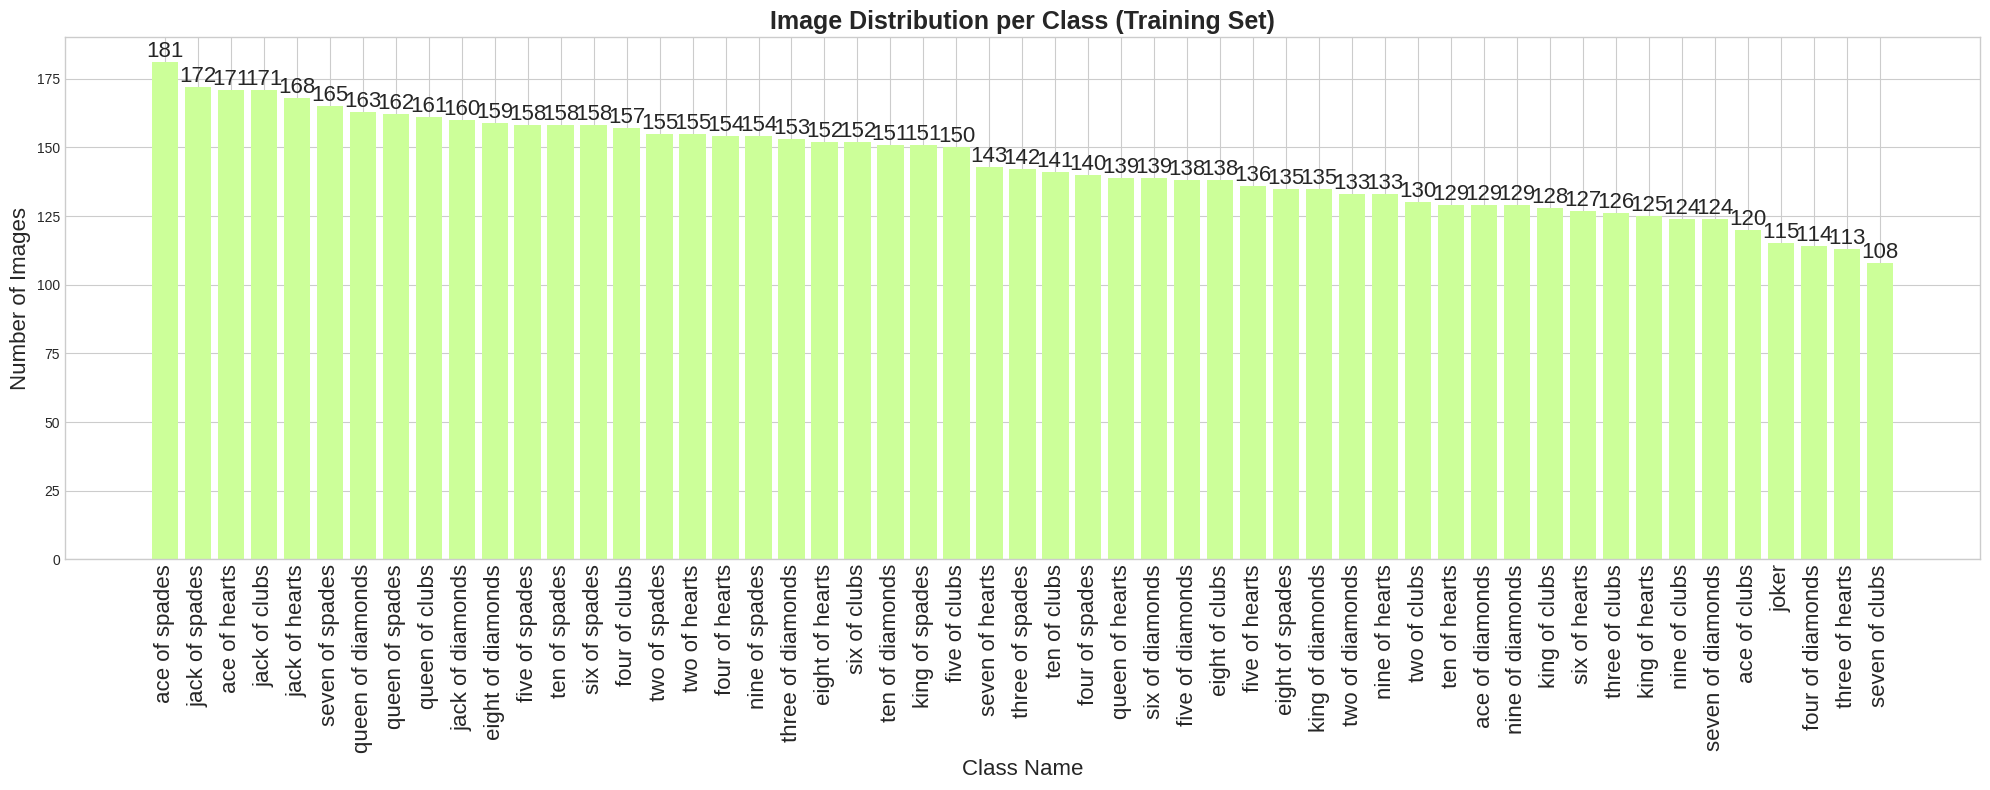

In [ ]:
#label distribution of train dataset
perform_eda(train_data_dir, 'Training')


--- Validation Set EDA ---
Total images: 265
Total classes: 53
Image distribution per class:
            Class  Count
     ace of clubs      5
  ace of diamonds      5
    ace of hearts      5
    ace of spades      5
   eight of clubs      5
eight of diamonds      5
  eight of hearts      5
  eight of spades      5
    five of clubs      5
 five of diamonds      5
   five of hearts      5
   five of spades      5
    four of clubs      5
 four of diamonds      5
   four of hearts      5
   four of spades      5
    jack of clubs      5
 jack of diamonds      5
   jack of hearts      5
   jack of spades      5
            joker      5
    king of clubs      5
 king of diamonds      5
   king of hearts      5
   king of spades      5
    nine of clubs      5
 nine of diamonds      5
   nine of hearts      5
   nine of spades      5
   queen of clubs      5
queen of diamonds      5
  queen of hearts      5
  queen of spades      5
   seven of clubs      5
seven of diamonds      5
  seve

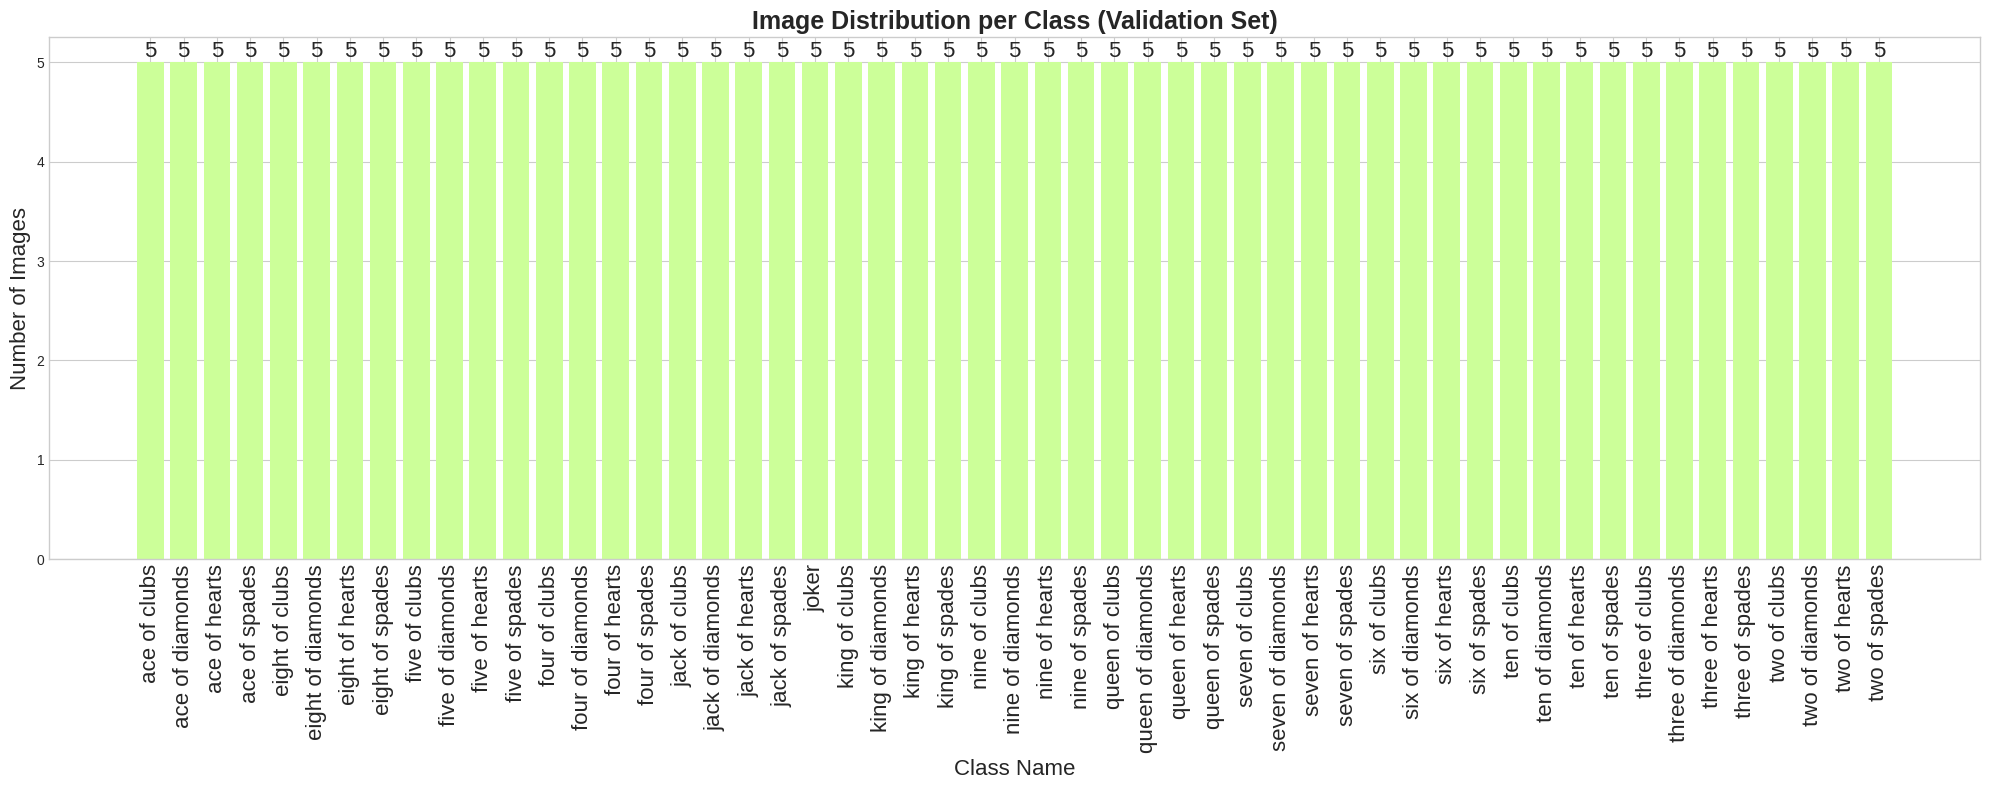

In [ ]:
#label distribution of valid dataset
perform_eda(val_data_dir, 'Validation')


--- Test Set EDA ---
Total images: 265
Total classes: 53
Image distribution per class:
            Class  Count
     ace of clubs      5
  ace of diamonds      5
    ace of hearts      5
    ace of spades      5
   eight of clubs      5
eight of diamonds      5
  eight of hearts      5
  eight of spades      5
    five of clubs      5
 five of diamonds      5
   five of hearts      5
   five of spades      5
    four of clubs      5
 four of diamonds      5
   four of hearts      5
   four of spades      5
    jack of clubs      5
 jack of diamonds      5
   jack of hearts      5
   jack of spades      5
            joker      5
    king of clubs      5
 king of diamonds      5
   king of hearts      5
   king of spades      5
    nine of clubs      5
 nine of diamonds      5
   nine of hearts      5
   nine of spades      5
   queen of clubs      5
queen of diamonds      5
  queen of hearts      5
  queen of spades      5
   seven of clubs      5
seven of diamonds      5
  seven of h

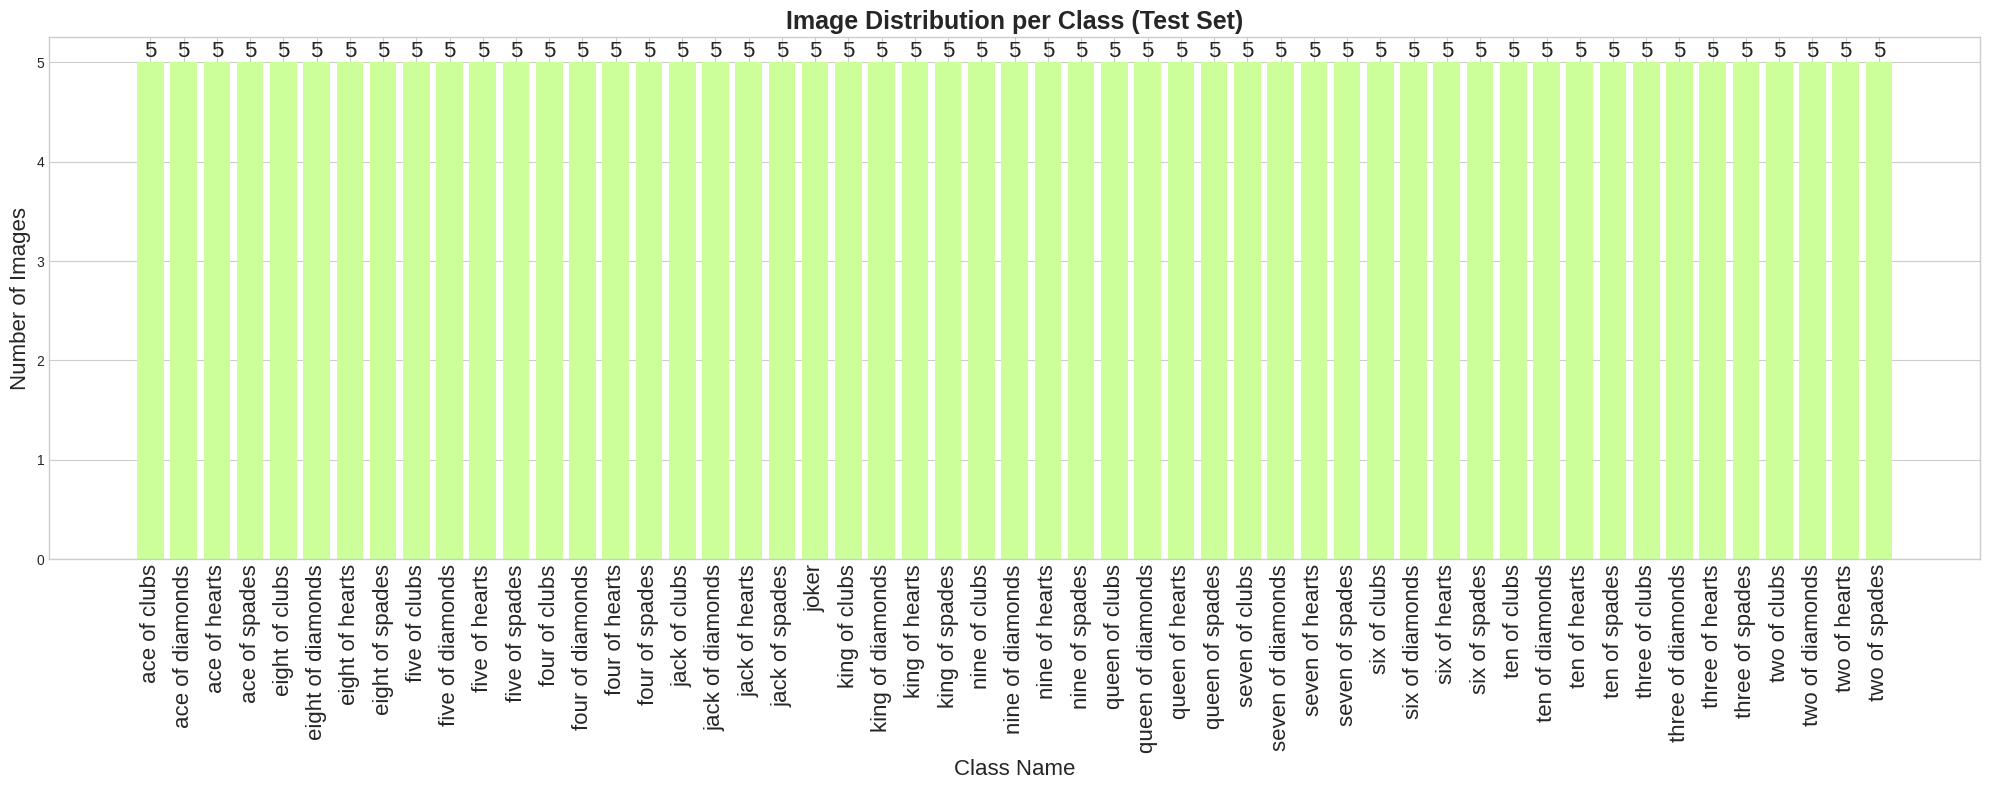

In [ ]:
#label distribution of test dataset
perform_eda(test_data_dir, 'Test')

Color channel distribution


--- Average Channel Values per Class ---
                     R_avg    G_avg    B_avg
ace of clubs      207.91   205.30   197.14  
ace of diamonds   214.71   201.90   195.20  
ace of hearts     204.34   188.91   185.27  
ace of spades     184.77   178.72   171.54  
eight of clubs    183.09   177.82   168.38  
eight of diamonds 205.06   181.94   174.52  
eight of hearts   208.86   181.92   174.90  
eight of spades   190.70   186.50   179.79  
five of clubs     197.10   193.64   186.64  
five of diamonds  212.51   194.91   188.06  
five of hearts    204.68   183.05   178.06  
five of spades    190.15   188.80   181.87  
four of clubs     196.66   192.66   185.46  
four of diamonds  212.63   197.34   190.45  
four of hearts    212.86   193.22   185.92  
four of spades    206.88   204.36   199.36  
jack of clubs     180.47   169.93   158.23  
jack of diamonds  185.64   169.82   159.56  
jack of hearts    183.27   163.58   153.57  
jack of spades    176.41   167.25   160.01  
joker        

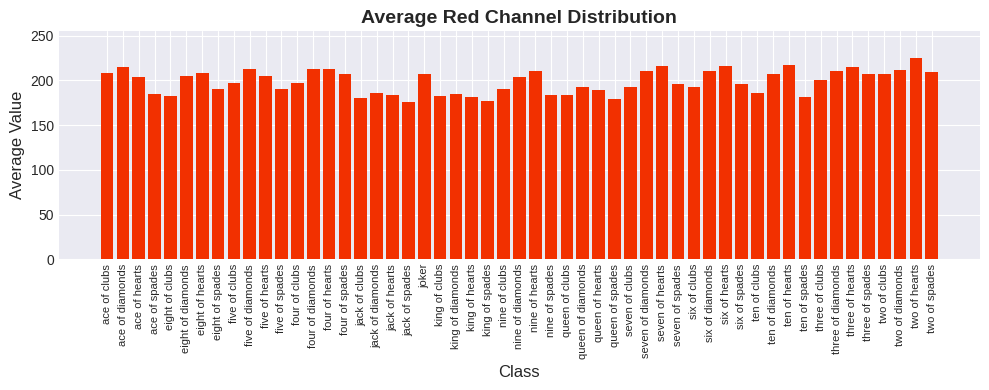

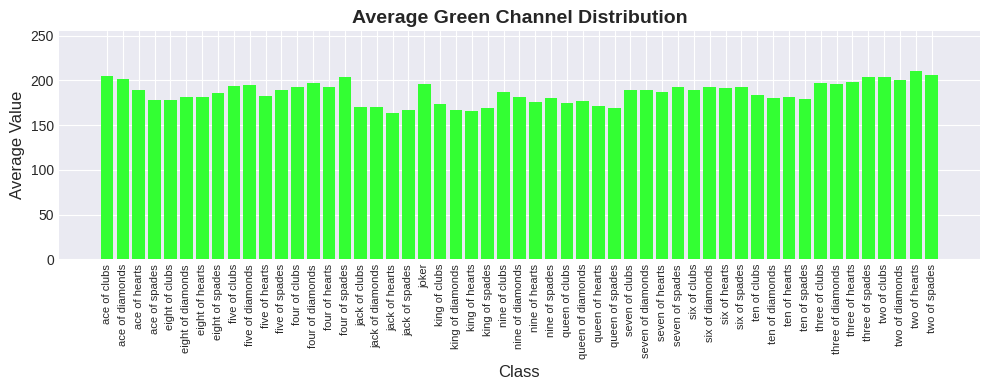

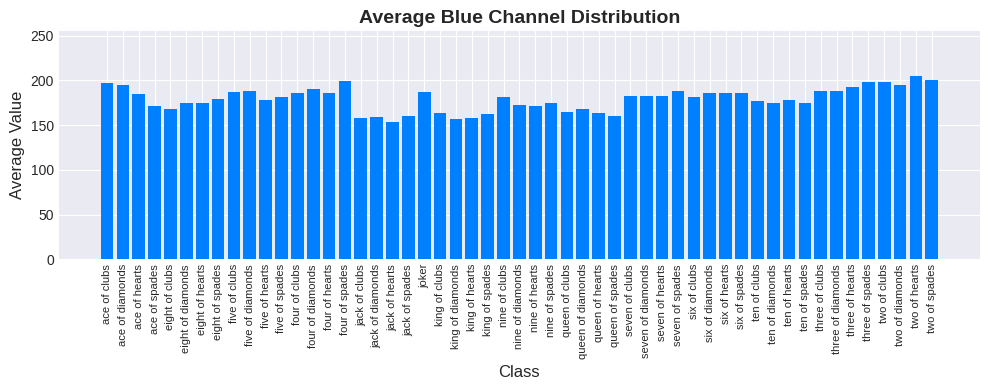

In [ ]:
#helper function for color channel distribution
def analyze_average_channels():
    """Analyzes and visualizes the average R, G, B channel values for each class across the entire dataset."""
    DATA_DIRECTORIES = {
        'train': train_data_dir,
        'valid': val_data_dir,
        'test': test_data_dir
    }

    all_data = defaultdict(lambda: {'R': [], 'G': [], 'B': []})
    for set_name, data_dir in DATA_DIRECTORIES.items():
        if not os.path.exists(data_dir):
            continue
        classes = sorted(os.listdir(data_dir))
        for cls in classes:
            class_path = os.path.join(data_dir, cls)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img_np = np.array(img)
                            all_data[cls]['R'].append(img_np[:,:,0].mean())
                            all_data[cls]['G'].append(img_np[:,:,1].mean())
                            all_data[cls]['B'].append(img_np[:,:,2].mean())
                    except Exception as e:
                        print(f"Could not read image {img_path}: {e}")

    average_data = {
        cls: {
            'R_avg': np.mean(all_data[cls]['R']),
            'G_avg': np.mean(all_data[cls]['G']),
            'B_avg': np.mean(all_data[cls]['B'])
        } for cls in all_data
    }

    avg_df = pd.DataFrame(average_data).T
    pd.options.display.float_format = '{:.2f}  '.format
    print("\n--- Average Channel Values per Class ---")
    print(avg_df.to_string())

    colors = ['#F23000', '#33FF33', '#0080FF']
    labels = ['Red', 'Green', 'Blue']
    channels_to_plot = ['R_avg', 'G_avg', 'B_avg']
    for i, channel in enumerate(channels_to_plot):
        plt.style.use('seaborn-v0_8-darkgrid')
        plt.figure(figsize=(10, 4))

        plt.bar(avg_df.index, avg_df[channel], color=colors[i])

        plt.title(f'Average {labels[i]} Channel Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Class', fontsize=12)
        plt.ylabel('Average Value', fontsize=12)
        plt.xticks(rotation=90, fontsize=8)
        plt.ylim(0, 255)

        plt.tight_layout()
        plt.show()

# Run the analysis
analyze_average_channels()

# 3. Extract feature vector

Set `EXTRACT_FEATURES` to `True` to re-extract the feature vectors, or to `False` to load the pre-extracted ones. The extraction process may take a few minutes. It uses these pretrained models to generate and save feature vectors:
 - resnet18
 - resnet34
 - resnet 50
 - efficientnet_b0
 - efficientnet_b3

In [ ]:
EXTRACT_FEATURES = False

In [ ]:
class CardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir,transform=transform)
        self.target_to_class = {v: k for k, v in self.data.class_to_idx.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

    def get_class_name(self,idx):
        return self.target_to_class[idx]

In [ ]:
#function for extracting and saving feature vectors
def extract_features(model_name:str,
                     input_size=(224,224),
                     batch_size=32,
                     data_dir='/content/datasets/'):
    print(f"--- Extracting features with {model_name.capitalize()} ---")
    model = timm.create_model(model_name, pretrained=True)
    config = resolve_data_config(model.pretrained_cfg)
    config['input_size'] = (3,*input_size)
    transform = create_transform(**config)
    model.reset_classifier(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    if not os.path.exists(f'/content/features/{model_name}'):
        os.makedirs(f'/content/features/{model_name}')

    for split in ['train', 'valid', 'test']:
        ds = CardDataset(f'/content/datasets/{split}', transform=transform)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
        features_list, labels_list = [], []
        with torch.no_grad():
            for imgs, labels in tqdm(loader, desc=f'Extracting {split} set'):
                feats = model(imgs.to(device))
                feats = feats.cpu().numpy()
                features_list.append(feats)
                labels_list.append(labels.numpy())
        features = np.concatenate(features_list, axis=0)
        labels = np.concatenate(labels_list, axis=0)
        np.save(f'/content/features/{model_name}/{split}_features.npy', features)
        np.save(f'/content/features/{model_name}/{split}_labels.npy', labels)
        print(features.shape, labels.shape)
    print(f"{model_name.capitalize()} features saved")

In [ ]:
#extract feature vectors using resnet18/34/50 and efficientnet_b0/b3 pretrained model
base_models = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b3']
if EXTRACT_FEATURES:
    for base_model in base_models:
        extract_features(base_model)
else:
    print("Feature extraction skipped.")

Feature extraction skipped.


In [ ]:
#load pre-extracted features vectors
if EXTRACT_FEATURES == False:
    import gdown
    import zipfile
    import os

    url = "https://drive.google.com/uc?id=1vanMezIITFxnK2-RgVJO2Fvbx-0oirrH"
    output = "features.zip"
    gdown.download(url, output, quiet=False)
    extract_dir = "/content/"
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1vanMezIITFxnK2-RgVJO2Fvbx-0oirrH
From (redirected): https://drive.google.com/uc?id=1vanMezIITFxnK2-RgVJO2Fvbx-0oirrH&confirm=t&uuid=95f7470b-f6b0-45fd-b2be-cb934ac6fa75
To: /content/features.zip
100%|██████████| 151M/151M [00:01<00:00, 95.3MB/s]


# 4. Modeling

Set `TRAIN_MODEL` to `True` to retrain the models, or to `False` to load the trained results. The training process may take ~ 50  minutes  
(~ 20 minutes with traditional models and ~ 30 minutes with deep models).

In [ ]:
TRAIN_MODEL = False

## Traditional model

Using the traditional models with the configuration below on pre-extracted feature vectors:

1. Logistic Regression, `penalty`: l2, None
2. Random Forests, `n_estimators`: 100, 150
3. SVM, `C`: 1, 10


In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


logistic_config = [{"penalty": p, "random_state": 42, "max_iter":1000} for p in ["l2", None]]
forest_config = [{"n_estimators": n, "random_state": 42} for n in [100, 150]]
svm_config = [{"C": n, "kernel": "linear"} for n in [1, 10]]

models = {
   'Logistic Regression': (LogisticRegression, logistic_config),
   'Random Forest': (RandomForestClassifier, forest_config),
   'SVM': (SVC, svm_config),
}
model_result = pd.DataFrame(columns=[
    "base_model",
    "classifier",
    "model_config",
    "accuracy",
    "precision",
    "recall",
    "f1"
])

This cell takes ~20 min to run

In [ ]:
#train traditional models
base_models = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b3']
if TRAIN_MODEL:
    for name, (classifier, model_configs) in models.items():
        start_time = time.time()
        for model_config in model_configs:
            model = classifier(**model_config)
            for base_model in tqdm(base_models, desc=f"Training {name}/{list(model_config.items())[0][0]}:{list(model_config.items())[0][1]}"):
                print(f"Training {name}/{base_model}...")
                train_features = np.load(f'/content/features/{base_model}/train_features.npy')
                train_labels = np.load(f'/content/features/{base_model}/train_labels.npy')
                test_features = np.load(f'/content/features/{base_model}/test_features.npy')
                test_labels = np.load(f'/content/features/{base_model}/test_labels.npy')

                model.fit(train_features, train_labels)
                preds = model.predict(test_features)

                accuracy = accuracy_score(test_labels, preds)
                precision = precision_score(test_labels, preds,average="macro",zero_division=0)
                recall = recall_score(test_labels, preds,average="macro")
                f1 = f1_score(test_labels, preds,average="macro",zero_division=0)

                model_result.loc[len(model_result)] = [
                    base_model,
                    name,
                    list(model_config.values())[0],
                    accuracy, precision, recall, f1
                ]
        end_time = time.time()
        elapsed_time = int(end_time - start_time)
        print(f"\nElapsed time for {name}: {elapsed_time // 60} minutes {elapsed_time % 60} seconds\n")
else:
    print("Training skipped.")

Training skipped.


## Deep learning model
End-to-end fine-tuning and head-classifier fine-tuning (using extracted feature vectors, pretrained backbone remains frozen) with these pretrained models:
 - resnet18
 - resnet34
 - resnet 50
 - efficientnet_b0
 - efficientnet_b3

In [ ]:
#define classes used for deep model
class FeatureDataset(Dataset):
    def __init__(self, base_model, split):
        fetures = np.load(f'/content/features/{base_model}/{split}_features.npy')
        labels = np.load(f'/content/features/{base_model}/{split}_labels.npy')
        self.x = torch.tensor(fetures, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class CardClassiferNet(nn.Module):
    def __init__(self,base_name,num_classes=53,end_to_end=True):
        match base_name:
            case 'resnet18':
                base_out = 512
            case 'resnet50':
                base_out = 2048
            case 'resnet34':
                base_out = 512
            case 'efficientnet_b0':
                base_out = 1280
            case 'efficientnet_b3':
                base_out = 1536
            case _:
                raise ValueError("Invalid base model name")

        super(CardClassiferNet, self).__init__()
        if end_to_end:
            self.base_model = timm.create_model(base_name, pretrained=True)
            self.f = nn.Sequential(*list(self.base_model.children())[:-1])
        else:
            self.f = nn.Identity()
            self.base_model = None

        self.classifier = nn.Sequential(
             nn.Flatten(),
             nn.Linear(base_out, num_classes),
        )

    def forward(self, x):
        x = self.f(x)
        output = self.classifier(x)
        return output

class CardClassifer(nn.Module):
    def __init__(self,
                 base_name='efficientnet_b3',
                 hidden_size=128,
                 num_classes=53,
                 batch_size=32,
                 end_to_end=True):
        super(CardClassifer, self).__init__()
        self.nn_net = CardClassiferNet(base_name,num_classes,end_to_end)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        if not end_to_end:
            train_ds = FeatureDataset(base_name,'train')
            val_ds = FeatureDataset(base_name,'valid')
            test_ds = FeatureDataset(base_name,'test')
        else:
            config = resolve_data_config(self.nn_net.base_model.pretrained_cfg)
            transform = create_transform(**config)
            train_ds = CardDataset(data_dir='/content/datasets/train', transform=transform)
            val_ds = CardDataset(data_dir='/content/datasets/valid', transform=transform)
            test_ds = CardDataset(data_dir='/content/datasets/test', transform=transform)

        self.train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        self.val_loader =  DataLoader(val_ds, batch_size=batch_size, shuffle=True)
        self.test_loader =  DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    def train(self,num_epochs=5,lr=0.005,plot_result=True):
      train_losses, val_losses = [], []
      self.nn_net.to(self.device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(self.nn_net.parameters(), lr=lr)

      for epoch in range(num_epochs):
          self.nn_net.train() #switch mode
          running_loss = 0.0
          for images, labels in tqdm(self.train_loader, desc='Training loop'):
              images, labels = images.to(self.device), labels.to(self.device)

              optimizer.zero_grad()
              outputs = self.nn_net(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              running_loss += loss.item() * labels.size(0)

          train_loss = running_loss / len(self.train_loader.dataset)
          train_losses.append(train_loss)

          self.nn_net.eval()
          running_loss = 0.0
          with torch.no_grad():
              for images, labels in tqdm(self.val_loader, desc='Validation loop'):
                  images, labels = images.to(self.device), labels.to(self.device)
                  outputs = self.nn_net(images)
                  loss = criterion(outputs, labels)
                  running_loss += loss.item() * labels.size(0)
          val_loss = running_loss / len(self.val_loader.dataset)
          val_losses.append(val_loss)
          print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

      if plot_result:
        plt.plot(train_losses, label='Training loss')
        plt.plot(val_losses, label='Validation loss')
        plt.legend()
        plt.title("Loss over epochs")
        plt.show()

    def evaluate(self):
        self.nn_net.eval()
        preds_list = []
        labels_list = []
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.nn_net(images)
                _, preds = torch.max(outputs, 1)
                preds_list.extend(preds.cpu().numpy())
                labels_list.extend(labels.cpu().numpy())
        preds_list = np.array(preds_list)
        labels_list = np.array(labels_list)
        acc  = accuracy_score(labels_list, preds_list)
        prec = precision_score(labels_list, preds_list, average="macro")
        rec  = recall_score(labels_list, preds_list, average="macro")
        f1   = f1_score(labels_list, preds_list, average="macro")
        return acc,prec,rec,f1


This cell may take ~30 minutes to run (with GPU)

In [ ]:
#train deep models
base_models = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b3']
if TRAIN_MODEL:
    start_time = time.time()
    for fine_tunning in ['end_to_end','head_classifier']:
        for base_model in base_models:
            print(f"Training Deep Model with {base_model}/{fine_tunning}...")
            model = CardClassifer(base_name=base_model,end_to_end=(fine_tunning=='end_to_end'))
            model.train(plot_result=False)
            accuracy, precision, recall, f1 = model.evaluate()
            model_result.loc[len(model_result)] = [
                    base_model,
                    "MLP",
                    fine_tunning,
                    accuracy, precision, recall, f1
                ]
            print(f'{base_model}/{fine_tunning}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}\n')
    end_time = time.time()
    elapsed_time = int(end_time - start_time)
    print(f"\nElapsed time: {elapsed_time // 60} minutes {elapsed_time % 60} seconds\n")
else:
    print("Training skipped.")

Training skipped.


In [ ]:
#model_result.to_csv("model_result.csv", index=False)

## Comparing models

In [ ]:
#load model result if not retrain
if TRAIN_MODEL == False:
    import gdown
    url = "https://drive.google.com/file/d/1oojMCKP8bn_mLwQR39W15MAqU5d3H4Fd/view?usp=sharing"
    output_file = "model_result.csv"
    gdown.download(url, output=output_file, fuzzy=True)
    model_result = pd.read_csv(output_file)

Downloading...
From: https://drive.google.com/uc?id=1oojMCKP8bn_mLwQR39W15MAqU5d3H4Fd
To: /content/model_result.csv
100%|██████████| 4.22k/4.22k [00:00<00:00, 11.0MB/s]


In [ ]:
model_result = model_result.fillna("None")
model_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   base_model    40 non-null     object 
 1   classifier    40 non-null     object 
 2   model_config  40 non-null     object 
 3   accuracy      40 non-null     float64
 4   precision     40 non-null     float64
 5   recall        40 non-null     float64
 6   f1            40 non-null     float64
dtypes: float64(4), object(3)
memory usage: 2.3+ KB


In [ ]:
model_result

,base_model,classifier,model_config,accuracy,precision,recall,f1
0,resnet18,Logistic Regression,l2,0.58,0.62,0.58,0.58
1,resnet34,Logistic Regression,l2,0.54,0.59,0.54,0.54
2,resnet50,Logistic Regression,l2,0.64,0.65,0.64,0.63
3,efficientnet_b0,Logistic Regression,l2,0.57,0.63,0.57,0.57
4,efficientnet_b3,Logistic Regression,l2,0.62,0.66,0.62,0.61
5,resnet18,Logistic Regression,None,0.51,0.54,0.51,0.51
6,resnet34,Logistic Regression,None,0.52,0.56,0.52,0.51
7,resnet50,Logistic Regression,None,0.55,0.56,0.55,0.54
8,efficientnet_b0,Logistic Regression,None,0.54,0.59,0.54,0.53
9,efficientnet_b3,Logistic Regression,None,0.57,0.61,0.57,0.56


In [ ]:
def highlight_row(row, idx):
    if row.name == idx:
        return ["background-color: gold"] * len(row)
    else:
        return [""] * len(row)

In [ ]:
from IPython.display import display

model_names = model_result.classifier.unique()
model_max_f1 = []
for name in model_names:
    df_result = model_result[model_result["classifier"] == name]
    max_f1_row_idx = df_result["f1"].idxmax()
    model_max_f1.append(max_f1_row_idx)
    styled_result = df_result.style.apply(highlight_row, axis=1, idx=max_f1_row_idx)

    print(f"{name} result:")
    display(styled_result)
    print(f"=> The best configuration for {name} is: f1-score = {df_result.loc[max_f1_row_idx, 'f1']}")
    print("* Model config")
    print(f"  - Pretrained base model: {df_result.loc[max_f1_row_idx, 'base_model']}")
    if name == "MLP":
        print(f"  - Fine-tuning type: {df_result.loc[max_f1_row_idx, 'model_config']}")
    else:
        print(f"  - {list(models[name][1][0].keys())[0]}: {df_result.loc[max_f1_row_idx, 'model_config']}")

    if name != 'MLP': print('\n-------------------------------------------------------------------------------------\n')

Logistic Regression result:


,base_model,classifier,model_config,accuracy,precision,recall,f1
0,resnet18,Logistic Regression,l2,0.584906,0.624671,0.584906,0.580303
1,resnet34,Logistic Regression,l2,0.543396,0.588248,0.543396,0.535712
2,resnet50,Logistic Regression,l2,0.641509,0.648839,0.641509,0.629456
3,efficientnet_b0,Logistic Regression,l2,0.569811,0.628227,0.569811,0.568867
4,efficientnet_b3,Logistic Regression,l2,0.615094,0.662174,0.615094,0.605577
5,resnet18,Logistic Regression,None,0.513208,0.543533,0.513208,0.511562
6,resnet34,Logistic Regression,None,0.516981,0.557465,0.516981,0.513976
7,resnet50,Logistic Regression,None,0.550943,0.564298,0.550943,0.538610
8,efficientnet_b0,Logistic Regression,None,0.539623,0.592376,0.539623,0.532270
9,efficientnet_b3,Logistic Regression,None,0.573585,0.609030,0.573585,0.563492


=> The best configuration for Logistic Regression is: f1-score = 0.6294560785126824
* Model config
  - Pretrained base model: resnet50
  - penalty: l2

-------------------------------------------------------------------------------------

Random Forest result:


,base_model,classifier,model_config,accuracy,precision,recall,f1
10,resnet18,Random Forest,100,0.475472,0.484083,0.475472,0.452050
11,resnet34,Random Forest,100,0.415094,0.455882,0.415094,0.403320
12,resnet50,Random Forest,100,0.475472,0.487626,0.475472,0.457623
13,efficientnet_b0,Random Forest,100,0.471698,0.532395,0.471698,0.456613
14,efficientnet_b3,Random Forest,100,0.381132,0.395038,0.381132,0.362915
15,resnet18,Random Forest,150,0.524528,0.545607,0.524528,0.505814
16,resnet34,Random Forest,150,0.430189,0.488391,0.430189,0.419610
17,resnet50,Random Forest,150,0.509434,0.521144,0.509434,0.496865
18,efficientnet_b0,Random Forest,150,0.456604,0.487397,0.456604,0.431914
19,efficientnet_b3,Random Forest,150,0.403774,0.443139,0.403774,0.392544


=> The best configuration for Random Forest is: f1-score = 0.5058140496819743
* Model config
  - Pretrained base model: resnet18
  - n_estimators: 150

-------------------------------------------------------------------------------------

SVM result:


,base_model,classifier,model_config,accuracy,precision,recall,f1
20,resnet18,SVM,1,0.603774,0.639221,0.603774,0.597155
21,resnet34,SVM,1,0.584906,0.640456,0.584906,0.575366
22,resnet50,SVM,1,0.618868,0.636208,0.618868,0.609524
23,efficientnet_b0,SVM,1,0.577358,0.619901,0.577358,0.573998
24,efficientnet_b3,SVM,1,0.577358,0.594856,0.577358,0.565665
25,resnet18,SVM,10,0.603774,0.619841,0.603774,0.594622
26,resnet34,SVM,10,0.588679,0.646251,0.588679,0.580461
27,resnet50,SVM,10,0.618868,0.637264,0.618868,0.610681
28,efficientnet_b0,SVM,10,0.577358,0.619901,0.577358,0.573998
29,efficientnet_b3,SVM,10,0.573585,0.591397,0.573585,0.561682


=> The best configuration for SVM is: f1-score = 0.610681456907872
* Model config
  - Pretrained base model: resnet50
  - C: 10

-------------------------------------------------------------------------------------

MLP result:


,base_model,classifier,model_config,accuracy,precision,recall,f1
30,resnet18,MLP,end_to_end,0.969811,0.976640,0.969811,0.969554
31,resnet34,MLP,end_to_end,0.958491,0.966577,0.958491,0.958157
32,resnet50,MLP,end_to_end,0.958491,0.968935,0.958491,0.958949
33,efficientnet_b0,MLP,end_to_end,0.898113,0.914286,0.898113,0.895316
34,efficientnet_b3,MLP,end_to_end,0.932075,0.943935,0.932075,0.929573
35,resnet18,MLP,head_classifier,0.539623,0.578956,0.539623,0.519261
36,resnet34,MLP,head_classifier,0.460377,0.528921,0.460377,0.432499
37,resnet50,MLP,head_classifier,0.558491,0.592097,0.558491,0.533188
38,efficientnet_b0,MLP,head_classifier,0.547170,0.618061,0.547170,0.531876
39,efficientnet_b3,MLP,head_classifier,0.550943,0.597442,0.550943,0.533943


=> The best configuration for MLP is: f1-score = 0.9695540308747856
* Model config
  - Pretrained base model: resnet18
  - Fine-tuning type: end_to_end


Top 5 F1-score model configurations

In [ ]:
from IPython.display import display

top5_f1 = df_result.nlargest(5, "f1").reset_index(drop=True)
top5_f1.index = top5_f1.index + 1
styled_result = top5_f1.style.apply(highlight_row, axis=1, idx=None)
display(styled_result)

,base_model,classifier,model_config,accuracy,precision,recall,f1
1,resnet18,MLP,end_to_end,0.969811,0.976640,0.969811,0.969554
2,resnet50,MLP,end_to_end,0.958491,0.968935,0.958491,0.958949
3,resnet34,MLP,end_to_end,0.958491,0.966577,0.958491,0.958157
4,efficientnet_b3,MLP,end_to_end,0.932075,0.943935,0.932075,0.929573
5,efficientnet_b0,MLP,end_to_end,0.898113,0.914286,0.898113,0.895316


Top F1-score configurations by model type

In [ ]:
max_f1_models = model_result.loc[model_max_f1]
best_model_idx = max_f1_models["f1"].idxmax()
max_f1_styled = max_f1_models.style.apply(highlight_row, axis=1, idx=best_model_idx)

print(f"The model with the highest f1-score is {model_result.loc[best_model_idx, 'classifier']}, with f1-score = {model_result.loc[best_model_idx, 'f1']}")
display(max_f1_styled)
print("\n* Model config")
print(f"  - Pretrained base model: {df_result.loc[best_model_idx, 'base_model']}")
if name == "MLP":
    print(f"  - Fine-tuning type: {df_result.loc[best_model_idx, 'model_config']}")
else:
    print(f"  - {list(models[name][1][0].keys())[0]}: {df_result.loc[best_model_idx, 'model_config']}")

The model with the highest f1-score is MLP, with f1-score = 0.9695540308747856


,base_model,classifier,model_config,accuracy,precision,recall,f1
2,resnet50,Logistic Regression,l2,0.641509,0.648839,0.641509,0.629456
15,resnet18,Random Forest,150,0.524528,0.545607,0.524528,0.505814
27,resnet50,SVM,10,0.618868,0.637264,0.618868,0.610681
30,resnet18,MLP,end_to_end,0.969811,0.976640,0.969811,0.969554



* Model config
  - Pretrained base model: resnet18
  - Fine-tuning type: end_to_end
